<a href="https://colab.research.google.com/github/hnishi/handson-language-models/blob/main/fine_tune_jp_bert_part02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# huggingface transformers を使って日本語 BERT モデルをファインチューニングして感情分析 (with google colab) part02

part01 に引き続いて、今回は、まとまったデータセットを使い、transformers の Trainer class を使いファインチューニングする方法を記載します。

また、学習後の評価方法に関しても記載します。

なお、今回はまとまった量 (4000 件程度) のデータを使って学習を行いますので、GPU の使用を推奨します (著者は google colab を使用して動作確認しています)。

---

この記事は、part02 です。

すべての記事の目次は以下をご参照ください。

https://github.com/hnishi/handson-language-models/blob/main/README.md

## 参考

- [huggingface transformers ドキュメント](https://huggingface.co/transformers/)
- [BERT 論文](https://arxiv.org/abs/1810.04805)
- [Fine-tuning a BERT model with transformers](https://towardsdatascience.com/fine-tuning-a-bert-model-with-transformers-c8e49c4e008b)

## 必要なライブラリのインストール

In [ ]:
!pip install -q transformers

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from transformers import AdamW

## ファインチューニングのための学習データの準備

株式会社リクルート 様が公開している [Japanese Realistic Textual Entailment Corpus (含意関係データセット) ](https://github.com/megagonlabs/jrte-corpus) を使わせていただきます。

下記、制限があるため注意します。

> リクルートは本データセットを非営利的な公共利用のために公開しています。分析・研究・その成果を発表するために必要な範囲を超えて利用すること（営利目的利用）は固く禁じます。

## References

1. 林部祐太．
    知識の整理のための根拠付き自然文間含意関係コーパスの構築．
    言語処理学会第26回年次大会論文集，pp.820-823. 2020. (NLP 2020)
    [[PDF]](https://www.anlp.jp/proceedings/annual_meeting/2020/pdf_dir/P4-9.pdf)
    [[Poster]](https://storage.googleapis.com/megagon-publications/nlp2020/p4-9_hayashibe_poster.pdf)
2. Yuta Hayashibe.
    Japanese Realistic Textual Entailment Corpus.
    Proceedings of The 12th Language Resources and Evaluation Conference, pp.6829-6836. 2020. (LREC 2020)
    [[PDF]](https://www.aclweb.org/anthology/2020.lrec-1.843.pdf)
    [[bib]](https://www.aclweb.org/anthology/2020.lrec-1.843.bib)

In [ ]:
!curl -L -O https://raw.githubusercontent.com/megagonlabs/jrte-corpus/master/data/pn.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  473k  100  473k    0     0  4465k      0 --:--:-- --:--:-- --:--:-- 4465k


In [ ]:
# 各カラムの意味は https://github.com/megagonlabs/jrte-corpus#datapntsv を参照
df = pd.read_csv("pn.tsv", sep='\t', header=None, 
                 names=["id", "label", "text", "judges", "usage"])

# ラベルを 1, 0, -1 --> 0, 1, 2 へ変換
# Label:	2 (Positive), 1 (Neutral), 0 (Negative)
df["label"] = df["label"] + 1

### データの確認

In [ ]:
df.head()

,id,label,text,judges,usage
0,pn17q00001,1,出張でお世話になりました。,"{""0"": 3}",test
1,pn17q00002,1,朝食は普通でした。,"{""0"": 3}",test
2,pn17q00003,2,また是非行きたいです。,"{""1"": 3}",test
3,pn17q00004,2,また利用したいと思えるホテルでした。,"{""1"": 3}",test
4,pn17q00005,2,駅から近くて便利でした。,"{""0"": 1, ""1"": 2}",test


### ラベルごとのデータ件数の確認

全体的に、positive なラベルが多いようです。

したがって、¥学習の結果 positive に極端に判定されやすいモデルとなってしまう可能性があるため注意が必要です。

評価指標に accuracy ではなく、F1 score などの不均衡データに関しても正しく評価できるものを選択する必要があります。

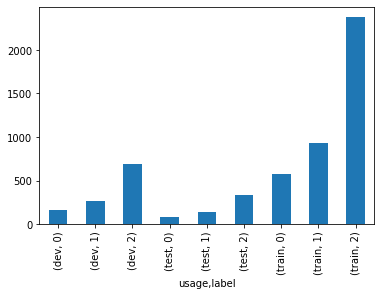

In [ ]:
df.groupby(["usage", "label"]).size().plot(kind='bar')

### カスタムデータセットに変換

後述する huggingface transformers の Trainer クラスで学習を行うために、カスタムデータセットとして準備します。

usage が train と dev のサンプルを学習用、test のサンプルをテスト用として分割します。

In [ ]:
df_train = df[df["usage"] == ("train" or "val")]
train_docs = df_train["text"].tolist()
train_labels = df_train["label"].tolist()
len(train_docs)

3888

In [ ]:
df_test = df[df["usage"] == "test"]
test_docs = df_test["text"].tolist()
test_labels = df_test["label"].tolist()
len(test_docs)

553

In [ ]:
# GPU が利用できる場合は GPU を利用する

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
model_name = "cl-tohoku/bert-large-japanese"

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
model = model.to(device)
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
train_encodings = tokenizer(train_docs, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
test_encodings = tokenizer(test_docs, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)

In [ ]:
import torch

class JpSentiDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = JpSentiDataset(train_encodings, train_labels)
test_dataset = JpSentiDataset(test_encodings, test_labels)

In [ ]:
# We can set `requires_grad` to `False` for all the base model parameters in order to fine-tune only the task-specific parameters.
# Ref: https://huggingface.co/transformers/training.html#freezing-the-encoder

for param in model.base_model.parameters():
    param.requires_grad = False

# For more detail, see https://korenv20.medium.com/do-we-need-to-freeze-embeddings-when-fine-tuning-our-lm-c8bccf4ffeba

In [ ]:
# To calculate additional metrics in addition to the loss, you can also define your own compute_metrics function and pass it to the trainer.

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.
    dataloader_pin_memory=False,  # Whether you want to pin memory in data loaders or not. Will default to True
    # evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    evaluation_strategy="steps",
    logging_steps=50,
    logging_dir='./logs'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,             # evaluation dataset
    compute_metrics=compute_metrics  # The function that will be used to compute metrics at evaluation
)

trainer.train()

In [ ]:
# evaluation のみ実行
trainer.evaluate(eval_dataset=test_dataset)

## 評価

学習の評価指標はデフォルトでは、 `runs/**CURRENT_DATETIME_HOSTNAME**` に出力されます。

tensorboard での可視化が可能です。

Ref: https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## fine tune したモデルで推論


In [ ]:
from transformers import pipeline

sentiment_analyzer = pipeline("sentiment-analysis", model=model.to("cpu"), tokenizer=model_name)

In [ ]:
sentiment_analyzer("私はこの映画をみることができて、とても嬉しい。")

In [ ]:
sentiment_analyzer("猫に足を噛まれて痛い。")

In [ ]:
list_text = [
             'この人は、この世の中で、いちばんしあわせな人にちがいありません。',
             '芝居小屋もすばらしいし、お客さんもすばらしい人たちでした。',
             'もし中世の時代だったら、おそらく、火あぶりにされたでしょうよ。',
             'みんなのうるさいことといったら、まるで、ハエがびんの中で、ブンブンいっているようでした。',
             'われわれ人間が、こういうことを考えだすことができるとすれば、われわれは、地の中にうめられるまでに、もっと長生きできてもいいはずだが'
]

In [ ]:
_ = list(map(lambda x: print(f"{x}: {sentiment_analyzer(x)}"), list_text))

## 学習済みモデルを保存

以下では、colab から google drive に保存する場合の例を示します。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
save_directory = "/content/drive/MyDrive/Colab Notebooks/trained_models/20210313_bert_sentiment_v3"

tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)